In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


In [3]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [6]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [7]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
0    18867
1     6260
2     6260
Name: count, dtype: int64


In [8]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize(image_size))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [9]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [10]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # может быть тензором с весами классов
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


In [12]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config, fold=0, criterion=None):
    # Удаляем фиксированный CrossEntropyLoss
    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'checkpoints/')
    num_epochs = config['training'].get('num_epochs', 20)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    scaler = GradScaler()

    if hasattr(model, 'vit'):
        for param in model.vit.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        if epoch == config['training'].get('freeze_encoder_epochs', 3):
            if hasattr(model, 'vit'):
                for param in model.vit.parameters():
                    param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds, all_probs, image_names = [], [], [], []
        hard_examples = []

        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                sample_losses = nn.functional.cross_entropy(logits, labels, reduction='none')

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

                for i in range(len(labels)):
                    if preds[i] != labels[i] or sample_losses[i].item() > 1.0:
                        hard_examples.append({
                            'image_name': filenames[i],
                            'true_label': labels[i].item(),
                            'pred_label': preds[i].item(),
                            'loss': sample_losses[i].item()
                        })

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            save_path = os.path.join(model_save_path, f"baseline_vit_fold{fold + 1}.pth")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)

        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(all_labels, all_preds):.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}")

    # AUC-ROC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)
    return all_labels, all_preds, all_probs, image_names



====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-8f2ef498c381>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-8f2ef498c381>:30: FutureWarning: 

Epoch 1/50 | Train Loss: 1.5020 | Val Loss: 1.4990
Epoch 2/50 | Train Loss: 1.4937 | Val Loss: 1.4910
Epoch 3/50 | Train Loss: 1.4859 | Val Loss: 1.4835
Epoch 4/50 | Train Loss: 1.3198 | Val Loss: 1.1309
Epoch 5/50 | Train Loss: 0.9704 | Val Loss: 0.8378
Epoch 6/50 | Train Loss: 0.7532 | Val Loss: 0.6912
Epoch 7/50 | Train Loss: 0.6360 | Val Loss: 0.6055
Epoch 8/50 | Train Loss: 0.5626 | Val Loss: 0.5526
Epoch 9/50 | Train Loss: 0.5149 | Val Loss: 0.5164
Epoch 10/50 | Train Loss: 0.4824 | Val Loss: 0.4927
Epoch 11/50 | Train Loss: 0.4559 | Val Loss: 0.4740
Epoch 12/50 | Train Loss: 0.4357 | Val Loss: 0.4619
Epoch 13/50 | Train Loss: 0.4199 | Val Loss: 0.4495
Epoch 14/50 | Train Loss: 0.4054 | Val Loss: 0.4400
Epoch 15/50 | Train Loss: 0.3932 | Val Loss: 0.4344
Epoch 16/50 | Train Loss: 0.3833 | Val Loss: 0.4304
Epoch 17/50 | Train Loss: 0.3740 | Val Loss: 0.4301
Epoch 18/50 | Train Loss: 0.3656 | Val Loss: 0.4225
Epoch 19/50 | Train Loss: 0.3583 | Val Loss: 0.4199
Epoch 20/50 | Train L

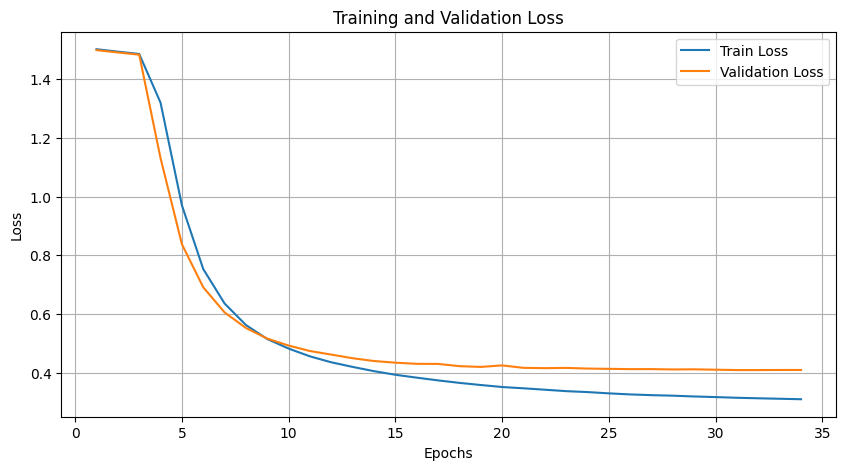


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-8f2ef498c381>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-8f2ef498c381>:30: FutureWarning: 

Epoch 1/50 | Train Loss: 1.5514 | Val Loss: 1.5481
Epoch 2/50 | Train Loss: 1.5415 | Val Loss: 1.5392
Epoch 3/50 | Train Loss: 1.5326 | Val Loss: 1.5309
Epoch 4/50 | Train Loss: 1.3675 | Val Loss: 1.2200
Epoch 5/50 | Train Loss: 1.0435 | Val Loss: 0.9008
Epoch 6/50 | Train Loss: 0.7889 | Val Loss: 0.7097
Epoch 7/50 | Train Loss: 0.6446 | Val Loss: 0.6108
Epoch 8/50 | Train Loss: 0.5610 | Val Loss: 0.5453
Epoch 9/50 | Train Loss: 0.5088 | Val Loss: 0.5080
Epoch 10/50 | Train Loss: 0.4738 | Val Loss: 0.4839
Epoch 11/50 | Train Loss: 0.4477 | Val Loss: 0.4632
Epoch 12/50 | Train Loss: 0.4282 | Val Loss: 0.4510
Epoch 13/50 | Train Loss: 0.4129 | Val Loss: 0.4399
Epoch 14/50 | Train Loss: 0.4011 | Val Loss: 0.4336
Epoch 15/50 | Train Loss: 0.3900 | Val Loss: 0.4247
Epoch 16/50 | Train Loss: 0.3810 | Val Loss: 0.4222
Epoch 17/50 | Train Loss: 0.3733 | Val Loss: 0.4183
Epoch 18/50 | Train Loss: 0.3645 | Val Loss: 0.4141
Epoch 19/50 | Train Loss: 0.3580 | Val Loss: 0.4110
Epoch 20/50 | Train L

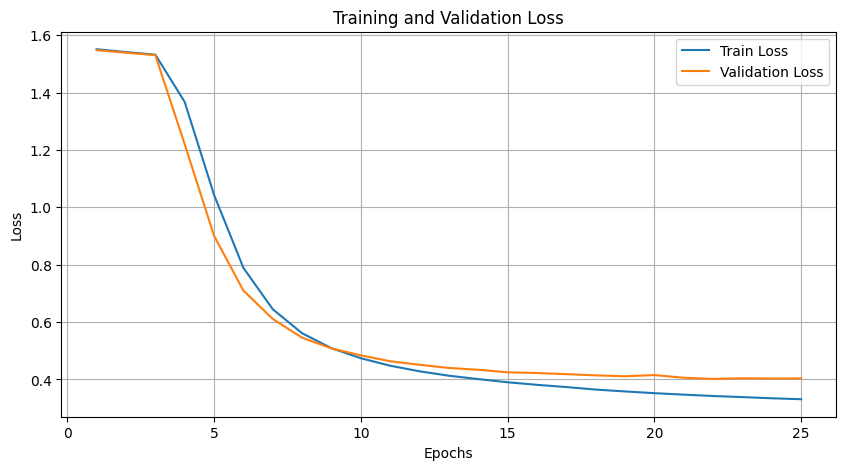


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-8f2ef498c381>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-12-8f2ef498c381>:30: FutureWarning: 

Epoch 1/50 | Train Loss: 1.4875 | Val Loss: 1.4858
Epoch 2/50 | Train Loss: 1.4806 | Val Loss: 1.4791
Epoch 3/50 | Train Loss: 1.4738 | Val Loss: 1.4727
Epoch 4/50 | Train Loss: 1.3164 | Val Loss: 1.1379
Epoch 5/50 | Train Loss: 0.9821 | Val Loss: 0.8493
Epoch 6/50 | Train Loss: 0.7582 | Val Loss: 0.6829
Epoch 7/50 | Train Loss: 0.6257 | Val Loss: 0.5858
Epoch 8/50 | Train Loss: 0.5476 | Val Loss: 0.5271
Epoch 9/50 | Train Loss: 0.4981 | Val Loss: 0.4883
Epoch 10/50 | Train Loss: 0.4640 | Val Loss: 0.4645
Epoch 11/50 | Train Loss: 0.4409 | Val Loss: 0.4464
Epoch 12/50 | Train Loss: 0.4212 | Val Loss: 0.4402
Epoch 13/50 | Train Loss: 0.4069 | Val Loss: 0.4241
Epoch 14/50 | Train Loss: 0.3936 | Val Loss: 0.4171
Epoch 15/50 | Train Loss: 0.3839 | Val Loss: 0.4104
Epoch 16/50 | Train Loss: 0.3746 | Val Loss: 0.4039
Epoch 17/50 | Train Loss: 0.3653 | Val Loss: 0.3996
Epoch 18/50 | Train Loss: 0.3586 | Val Loss: 0.3988
Epoch 19/50 | Train Loss: 0.3522 | Val Loss: 0.3929
Epoch 20/50 | Train L

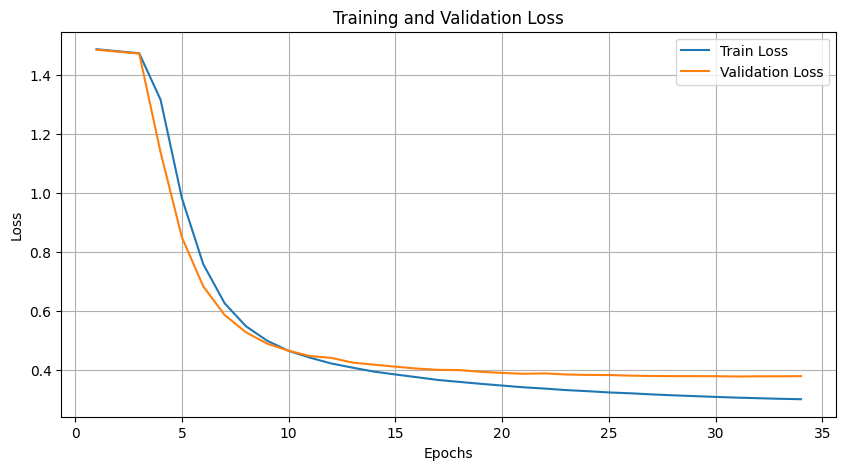


Все фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'


In [14]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import os

# === KFold и обучение ===
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")

    # Подготовка данных для текущего фолда
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # Создание датасетов
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    # DataLoader'ы
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    # Модель
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    # Оптимизатор
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler
    scheduler_type = config['training'].get('scheduler', 'cosine').lower()
    if scheduler_type == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_type}")

    config['training']['model_save_path'] = f"best_model_fold{fold + 1}.pth"

     # --- Расчёт весов классов и инициализация FocalLoss ---
    class_counts = train_df['true_label'].value_counts().sort_index().values
    total_samples = class_counts.sum()
    class_weights = [total_samples / c for c in class_counts]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    focal_loss_fn = FocalLoss(gamma=2.0, alpha=class_weights_tensor)

    # Обучение
    labels, preds, probs, image_names = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, config,
        fold=fold, criterion=focal_loss_fn
    )


    # Сохранение результатов
    fold_df = pd.DataFrame({
        'image_name': image_names,
        'true_label': labels,
        'pred_label': preds,
        'fold': fold + 1
    })
    all_results.append(fold_df)

# Итоговые результаты всех фолдов
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv("kfold_vit_predictions.csv", index=False)
print("\nВсе фолды завершены. Результаты сохранены в 'kfold_vit_predictions.csv'")
